# XGBoost: Extreme Gradiente Boosting

In [1]:
# libraries

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# xgboost regression
from xgboost import XGBRegressor, XGBRFRegressor

# xgboost clasification
from xgboost import XGBClassifier, XGBRFClassifier

# sklearn
from sklearn.datasets import load_boston, fetch_california_housing, load_wine
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

## `load_boston()` y `fetch_california_housing()`
Vamos a utilizar dos bases de datos para predecir el precio de propiedades:

In [3]:
boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
california = fetch_california_housing()
print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [5]:
data_boston = pd.DataFrame(boston.data, columns = boston.feature_names)
data_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [6]:
data_california = pd.DataFrame(california.data, columns = california.feature_names)
data_california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [7]:
data_boston.shape, data_california.shape

((506, 13), (20640, 8))

El objetivo de nuestros modelos será predecir el precio de las propiedades en Boston y California

In [8]:
# vamos a incluir las etiquetas (.target) dentro de los dataframes

data_boston['Price'] = boston.target
data_california['Price'] = california.target

display(data_boston.head())
display(data_california.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [9]:
Xb, yb = boston.data, boston.target
Xc, yc = california.data,data_california.iloc[:,-1]

The next step is just an optimization for performance...

## `train_test_split`

In [10]:
# si bien no es necesario transformar los datos a DF, nos va a convenir hacerlo para unos pasos más adelante
# cuando querramos hacer unos gráficos
Xb, yb = data_boston.iloc[:,:-1],data_boston.iloc[:,-1]
Xc, yc = data_california.iloc[:,:-1],data_california.iloc[:,-1]

Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=42)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=50)

In [11]:
Xb_train.shape, yb_train.shape

((404, 13), (404,))

In [12]:
Xb_test.shape, yb_test.shape

((102, 13), (102,))

In [13]:
Xc_train.shape, yc_train.shape

((16512, 8), (16512,))

In [14]:
Xc_test.shape, yc_test.shape

((4128, 8), (4128,))

## `XGBRegressor()` y `XGBRFRegressor()`

In [15]:
# definimos una variable que luego vamos a usar como argumento de las clases de los modelos
argumentos = dict( objective = 'reg:squarederror',
                  colsample_bytree = 0.3,
                  learning_rate = 0.2,
                  max_depth = 10,
                  alpha = 50,
                  n_estimators = 5
                 )

In [16]:

# 1. Instanciamos los modelos
# Lo vamos a hacer de una manera un poco diferente a como lo veníamos haciendo
# Vamos a generar una lista de modelos instanciados ya que luego vamos a iterar sobre esta lista


xg_reg_boston = [XGBRegressor(**argumentos), # definimos los hiperparámetros que elegimos en la celda anterios
                 XGBRFRegressor()            # dejamos los hiperparámetros definidos por defecto
                ]

xg_reg_california = [XGBRegressor(**argumentos), # definimos los hiperparámetros que elegimos en la celda anterios
                     XGBRFRegressor()
                    ]

In [17]:
# armamos una tuplas con variables que luego vamos a necesitar para iterar sobre los modelos

boston_set = (xg_reg_boston, Xb_train, yb_train, Xb_test, yb_test)
california_set = (xg_reg_california, Xc_train, yc_train, Xc_test, yc_test)

In [18]:
count = 1
for (ml_model, X_train, y_train, X_test, y_test) in (boston_set, california_set):
    for model in ml_model:
        print(f' Model {count} '.center(75, '='))
        count += 1
        print(model)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        print(f'\nRoot-mean-square error: {rmse}\n')

================================= Model 1 =================================
XGBRegressor(alpha=50, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=5, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, ...)

Root-mean-square error: 9.0683500246166

================================= Model 2 =================================
XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_by

**Conclusión Parcial:** Analizando el error cuadrático medio vemos que tanto para el dataser de Boston como para el de california el modelo XGBRFRegressor funciona mejor que el XGBRegressor.

======================================================= Model 1 ========================================================


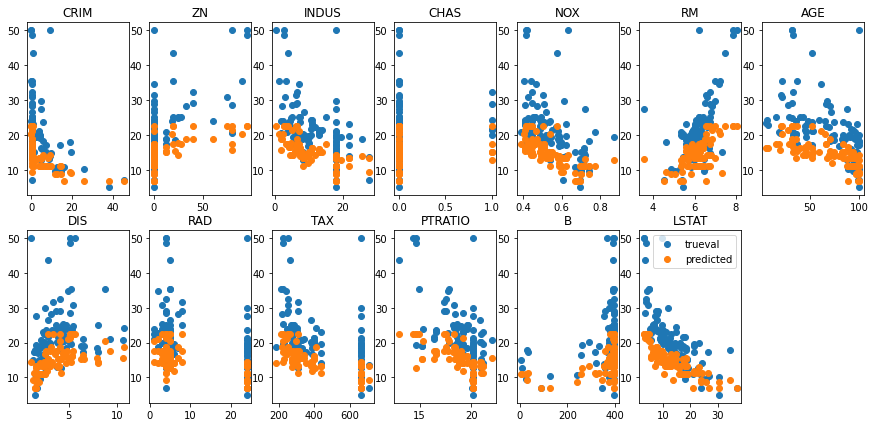

======================================================= Model 2 ========================================================


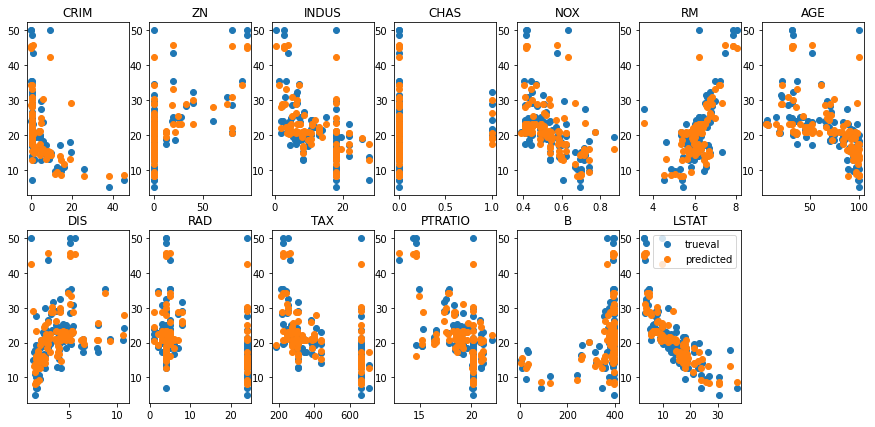

======================================================= Model 3 ========================================================


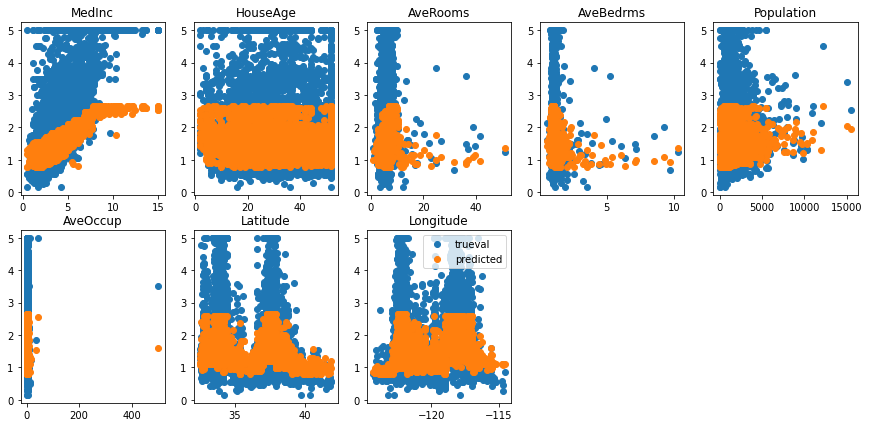

======================================================= Model 4 ========================================================


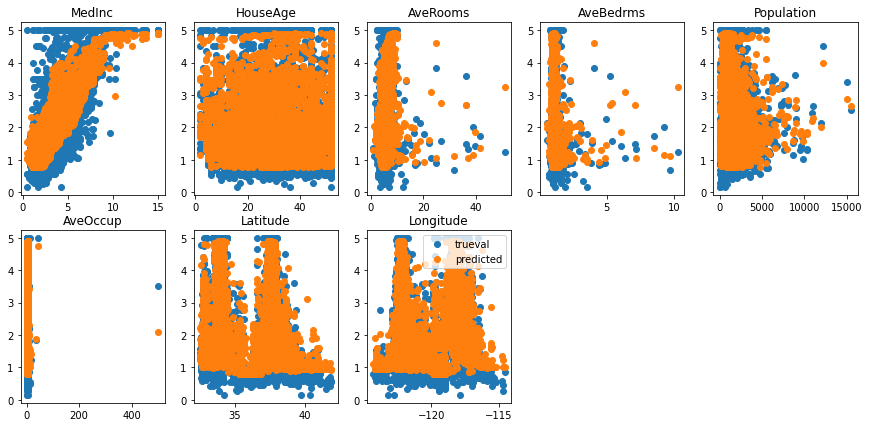

In [19]:

count = 1
for (ml_model, X_train, y_train, X_test, y_test) in (boston_set, california_set):
    for model in ml_model:
        print(f' Model {count} '.center(120, '='))
        count += 1
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        plt.figure(figsize = (15,7))
        for i, var in enumerate(X_test):
            plt.subplot(2, int(X_test.shape[1]/2) + 1, i+1)
            plt.scatter(X_test.loc[:,var],y_test, label='trueval')
            plt.scatter(X_test.loc[:,var],preds, label='predicted')
            plt.title(var)
        plt.legend()
        plt.show()

**Conslusión Parcial:** Nuevamente vemos que los modelos basados en XGBRFRegressor funcionan mucho mejor que los modelos basados en XGBRegressor()

## `RandomForestClassifier` | `XGBClassifier` | `XGBRFClassifier` Clasificación

In [20]:
iris = load_wine()

X = iris["data"]
y = iris["target"]

FOLDS=4
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=4)

El parámetro `objective` es la función objetivo a minimizar. Para problemas de clasificación multiclase usualmente usamos `multi:softmax` debido a que da una "probabilidad" para cada clase. 

Tiene la forma:

$\sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^K{e^{z_j}}}$ para $i=1, \dots, K$ y $\mathbf{z} = (z_1, \dots, z_K) \in \mathbb{R}^K $

Se puede ver la [documentacion](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters) para otras funciones objetivo.

In [21]:
clfs = [XGBClassifier(objective = "multi:softmax", colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 10),
        XGBRFClassifier(objective = "multi:softmax", colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 10),
        RandomForestClassifier()]

clfs_names = ['XGBC', 'XGBRFC', 'RF']


XGBC
Acc. fold 1: 95.56
Acc. fold 2: 95.56
Acc. fold 3: 100.00
Acc. fold 4: 97.73
Avg. accuracy = 97.20959595959597
XGBRFC
Acc. fold 1: 95.56
Acc. fold 2: 95.56
Acc. fold 3: 100.00
Acc. fold 4: 90.91
Avg. accuracy = 95.50505050505052
RF
Acc. fold 1: 97.78
Acc. fold 2: 97.78
Acc. fold 3: 97.73
Acc. fold 4: 97.73
Avg. accuracy = 97.75252525252525


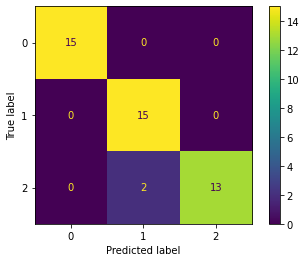

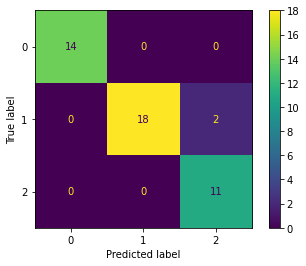

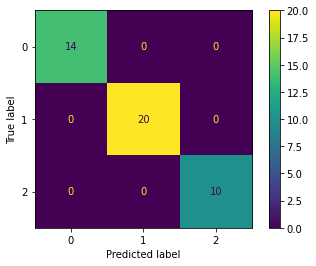

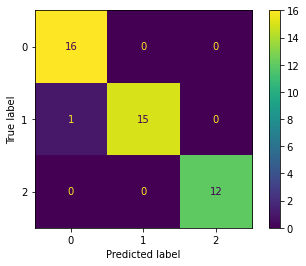

In [22]:
for clf, name in zip(clfs, clfs_names):
    avg_accuracy = 0
    print(name)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X,y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[val_idx], y[val_idx]
        clf.fit(X_train,y_train)
        preds = clf.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        avg_accuracy +=accuracy
        print(f"Acc. fold {fold+1}: {accuracy * 100.0 :.2f}" % ())
        if name == 'XGBC':
            ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100}')

### Esta linea la agregué de VS Code